In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_df = pd.read_table('ml-100k/u1.base',header=None,encoding='gb2312',delim_whitespace=True,index_col=None)
test_df = pd.read_table('ml-100k/u1.test',header=None,encoding='gb2312',delim_whitespace=True,index_col=None)

train_df = train_df.drop(3, axis=1)
train_df.columns = ['user_id','item_id','rating']
test_df = test_df.drop(3, axis=1)
test_df.columns = ['user_id','item_id','rating']

train = train_df.values
test = test_df.values

all_df = pd.concat([train_df, test_df],ignore_index=True)
n_users = len(set(all_df['user_id']))
n_items = len(set(all_df['item_id']))
print('number of users:',n_users)
print('number of items:',n_items)

number of users: 943
number of items: 1682


In [3]:
#used for loss_vector
train_set = pd.concat([test_df, train_df],ignore_index=True)
train_set.loc[range(len(test_df)),'rating'] = 0
train_R = train_set.pivot(index='user_id',columns='item_id',values='rating').fillna(0)
train_R = train_R.values

test_set = pd.concat([train_df, test_df],ignore_index=True)
test_set.loc[range(len(train_df)),'rating'] = 0
test_R = test_set.pivot(index='user_id',columns='item_id',values='rating').fillna(0)
test_R = test_R.values

In [4]:
def loss(dataset, P, Q, reg):
    error = 0
    for row in dataset: #user_id, item_id, score
        user_id = row[0]-1#start from 1
        item_id = row[1]-1
        rating = row[2]
        error += np.square(rating - np.dot(P[user_id, :], Q[item_id,:]))
    return error / dataset.shape[0] + 1/2 * reg * (np.sum(P * P)+np.sum(Q * Q))

def loss_vector(R, P, Q, reg, n_samples):
    error = R - np.dot(P, Q.T)
    error[R==0] = 0
    #tr(A^TA)<=>np.sum(A*A)
    return np.trace(np.dot(error.T, error))/n_samples + 1/2 * reg * (np.sum(P * P)+np.sum(Q * Q))

In [44]:
#latent features
K = 10
#hyper-parameters
reg = 0.01
learning_rate = 0.005
max_iteration = 20000

#initialization
P = np.random.rand(n_users,K)
Q = np.random.rand(n_items,K)

#validating vector operation
print('training loss:',loss_vector(train_R, P, Q, reg, train.shape[0]), loss(train, P, Q, reg))
print('testing loss:',loss_vector(test_R, P, Q, reg, test.shape[0]), loss(test, P, Q, reg))

training loss: 46.5029509938 46.5029509938
testing loss: 46.6494630899 46.6494630899


In [45]:
# SGD
# randomly pick a sample
SGD_train_loss_history = []
SGD_test_loss_history = []
for i in range(max_iteration):
    idx = np.random.randint(len(train))
    row = train[idx]
    user_id = row[0]-1
    item_id = row[1]-1
    rating = row[2]
    error = rating - np.dot(P[user_id, :], Q[item_id, :])
    P[user_id, :] = P[user_id, :] - learning_rate * (-2 * error * Q[item_id, :] + P[user_id, :])
    Q[item_id, :] = Q[item_id, :] - learning_rate * (-2 * error * P[user_id, :] + Q[item_id, :])
    
    train_loss = loss_vector(train_R, P, Q, reg, train.shape[0])
    test_loss = loss_vector(test_R, P, Q, reg, test.shape[0])
    SGD_train_loss_history.append(train_loss)
    SGD_test_loss_history.append(test_loss)
    if i % 50 == 0:
        print(i, train_loss, test_loss)

0 46.5034866277 46.6500932382
50 46.4928133512 46.6372172235
100 46.4862813452 46.6299472874
150 46.4837502505 46.6284917937
200 46.4763696494 46.6203238357
250 46.4715719418 46.6158011385
300 46.4696588926 46.6157313346
350 46.4650429744 46.6107633932
400 46.4598364251 46.6065327501
450 46.4615319669 46.6080334131
500 46.4566165492 46.6045537846
550 46.4514351703 46.5990249582
600 46.4456659726 46.5937162412
650 46.441448005 46.5893321116
700 46.4368893137 46.5842738329
750 46.4364334213 46.5860517722
800 46.4294771304 46.5783162236
850 46.426134343 46.5739383969
900 46.424798122 46.5764290915
950 46.4214568991 46.574520144
1000 46.40897251 46.5614159202
1050 46.4057944338 46.5570222372
1100 46.4024372278 46.5548532389
1150 46.3967722903 46.5472541098
1200 46.3931497802 46.5439537342
1250 46.3852225033 46.5365950944
1300 46.3759252458 46.5261001481
1350 46.3726596561 46.5238645166
1400 46.3668915268 46.5204768755
1450 46.3621242623 46.5188779544
1500 46.3623657342 46.5162176274
1550 4

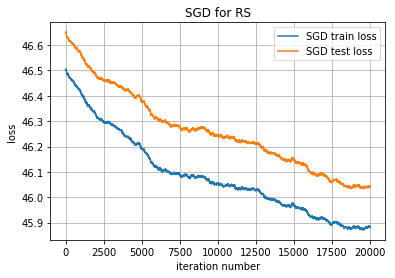

In [46]:
plt.title('SGD for RS')
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.plot(range(len(SGD_train_loss_history)), SGD_train_loss_history, label='SGD train loss')
plt.plot(range(len(SGD_test_loss_history)), SGD_test_loss_history, label='SGD test loss')
plt.legend()
plt.grid()
plt.show()